<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** José Leonardo Aceves y Tania Bell Nicholls

**Fecha:** 23 de noviembre 2021.

**Expediente** : IF712626 y IF726767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/leonardoaceves/Tarea8_JLACEVES_TNICHOLLS.git

# Tarea 8: Clase 22

Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

Código de solucion, Leonardo Aceves

In [2]:
#Paqueterias
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import yfinance as yf
from datetime import date

%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [35]:
def options_yf(ticker):
    stock = yf.Ticker(ticker)
    calls, puts = stock.option_chain(stock.options[0]) 
    return calls, puts

# Código de solución estudiante 2: Tania Bell

### Importación de closes y opciones

In [56]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    '''
    Función que accede a los datos en yahoo dado tickers y la fecha de inicio y la fecha final
    '''
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

# Función para cálcular los rendimientos diarios
def calc_daily_ret(closes):
    '''
    Función para calcular los rendimientos diarios de cierres de acciones
    '''
    return np.log(closes/closes.shift(1)).iloc[1:]

# Función opciones
def options_chain(symbol):
    '''
    Función que obtiene los datos de yahoo finance usando yfinance dando un ticker
    '''
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options

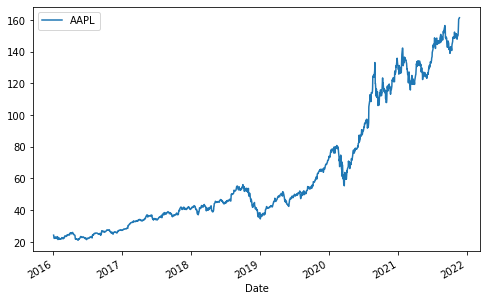

In [4]:
# importamos cierres diarios de la empresa
ticker = ['AAPL']
start_date = '2016-01-01'

closes_aapl = get_adj_closes(ticker, start_date)
closes_aapl.plot(figsize=(8,5));
plt.legend(ticker);

In [5]:
#ultimo cierre de la empresa
closes_aapl.iloc[-1]

Symbols
AAPL    161.41
Name: 2021-11-23 00:00:00, dtype: float64

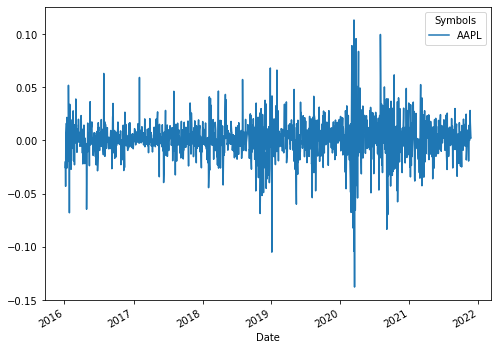

In [7]:
# calculamos los rendimientos diarios
ret_aapl = calc_daily_ret(closes_aapl)
ret_aapl.plot(figsize=(8,6));

In [9]:
#importamos información de opciones de la empresa para escoger nuestro put
aapl_opt = options_chain('AAPL')
#aapl_opt = aapl_opt.set_index('expirationDate').sort_index()
aapl_opt

,contractSymbol,strike,bid,...,dte,CALL,mark
0,AAPL211126C00075000,75.0,86.00,...,0.008,True,86.475
1,AAPL211126C00080000,80.0,81.35,...,0.008,True,81.650
2,AAPL211126C00085000,85.0,76.20,...,0.008,True,76.425
3,AAPL211126C00090000,90.0,71.20,...,0.008,True,71.625
4,AAPL211126C00095000,95.0,66.15,...,0.008,True,66.425
...,...,...,...,...,...,...,...
1928,AAPL240119P00235000,235.0,78.00,...,2.156,False,80.500
1929,AAPL240119P00240000,240.0,82.50,...,2.156,False,85.000
1930,AAPL240119P00245000,245.0,87.00,...,2.156,False,89.500
1931,AAPL240119P00250000,250.0,91.50,...,2.156,False,93.750


In [11]:
# opción que quiero evaluar
K = 175.0 # strike price
indice_opt = aapl_opt.loc[(aapl_opt.CALL==False) & (aapl_opt.strike==K) &(aapl_opt.expirationDate=='2021-12-24')]
indice_opt

,contractSymbol,strike,bid,...,dte,CALL,mark
426,AAPL211223P00175000,175.0,14.5,...,0.082,False,14.6


In [12]:
# información de opción elegida
i_opt= indice_opt.index
opcion_valuar = aapl_opt.loc[i_opt[0]]
opcion_valuar

contractSymbol    AAPL211223P00175000
strike                          175.0
bid                              14.5
ask                              14.7
volume                            7.0
                         ...         
inTheMoney                       True
expirationDate    2021-12-24 00:00:00
dte                             0.082
CALL                            False
mark                             14.6
Name: 426, Length: 12, dtype: object

## Simulación de precios

In [13]:
# rendimiento simple en dataframe
Ri = closes_aapl.pct_change(1).iloc[1:]
# Obtenemos su media y desviación estándar de los rendimientos
mu_R = Ri.mean()[0]
sigma_R = Ri.std()[0]
Ri

Symbols,AAPL
Date,
2016-01-05,-0.025
2016-01-06,-0.020
2016-01-07,-0.042
2016-01-08,0.005
2016-01-11,0.016
...,...
2021-11-17,0.016
2021-11-18,0.029
2021-11-19,0.017


In [14]:
today = pd.Timestamp(date.today())
expiry = '2022-02-18'

nscen = 10000
dates = pd.date_range(start=today, end=expiry, freq='B')
ndays = len(dates)
dates, ndays

(DatetimeIndex(['2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
                '2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02',
                '2021-12-03', '2021-12-06', '2021-12-07', '2021-12-08',
                '2021-12-09', '2021-12-10', '2021-12-13', '2021-12-14',
                '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20',
                '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
                '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
                '2021-12-31', '2022-01-03', '2022-01-04', '2022-01-05',
                '2022-01-06', '2022-01-07', '2022-01-10', '2022-01-11',
                '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
                '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
                '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
                '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02',
                '2022-02-03', '2022-02-04', '2022-02-07', '2022-

### Simular precios usando rendimiento

In [15]:
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)
# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(mu_R*dt+Z*sigma_R*np.sqrt(dt),index=dates)
Ri_dt.cumprod()

,0,1,2,...,9997,9998,9999
2021-11-23,-1.682e-03,6.874e-04,9.239e-03,...,-1.070e-02,1.479e-03,2.719e-03
2021-11-24,-3.285e-06,1.256e-05,4.364e-05,...,1.912e-04,-1.459e-06,1.614e-05
2021-11-25,-3.861e-08,4.631e-07,1.717e-07,...,4.724e-06,-2.189e-08,-2.871e-07
2021-11-26,-9.355e-10,7.037e-09,-7.649e-10,...,-5.374e-08,4.404e-10,2.361e-09
2021-11-29,-4.074e-12,-1.241e-10,-7.838e-13,...,-9.552e-10,1.639e-11,-2.002e-11
...,...,...,...,...,...,...,...
2022-02-14,-3.617e-121,-2.873e-122,-3.953e-119,...,-2.077e-115,2.997e-117,-8.624e-125
2022-02-15,1.721e-122,1.177e-124,-6.120e-122,...,9.129e-117,6.067e-119,1.503e-126
2022-02-16,2.997e-124,5.199e-127,1.707e-123,...,-4.790e-119,-4.185e-121,-6.250e-129
2022-02-17,2.649e-126,1.497e-128,-1.166e-125,...,6.730e-121,-1.392e-122,-1.869e-130


In [16]:
# simulacion del precio
S_0 = closes_aapl.iloc[-1,0]
S_T = S_0*(1+Ri_dt).cumprod()

#pd.concat([closes_aapl,S_T]).plot(figsize=(8,6));
#plt.title('Simulación de precios usando rendimiento simple');
S_T

,0,1,2,...,9997,9998,9999
2021-11-23,161.139,161.521,162.901,...,159.683,161.649,161.849
2021-11-24,161.453,164.472,163.671,...,156.830,161.489,162.809
2021-11-25,163.351,170.537,164.315,...,160.705,163.913,159.912
2021-11-26,167.309,173.128,163.583,...,158.877,160.616,158.597
2021-11-29,168.037,170.074,163.751,...,161.701,166.592,157.252
...,...,...,...,...,...,...,...
2022-02-14,221.553,236.324,172.115,...,180.856,163.945,140.736
2022-02-15,211.011,235.356,172.382,...,172.906,167.263,138.284
2022-02-16,214.686,236.396,167.574,...,171.998,166.110,137.709
2022-02-17,216.583,243.202,166.429,...,169.582,171.634,141.826


### Rendimiento Logaritmico

In [17]:
ri = calc_daily_ret(closes_aapl)
# Usando la media y desviación estándar de los rendimientos logarítmicos
mu_r = ri.mean()[0]
sigma_r = ri.std()[0]

# # Usando la equivalencia teórica
# mu_r2 = mu_R - (sigma_R**2)/2

sim_ret_ri = pd.DataFrame(mu_r*dt+Z*sigma_r*np.sqrt(dt), index=dates)

# Simulación del precio
S_0 = closes_aapl.iloc[-1,0]
S_T2 = S_0*np.exp(sim_ret_ri.cumsum())

# Se muestran los precios simulados con los precios descargados
# pd.concat([closes_aapl,S_T2]).plot(figsize=(8,6));
# plt.title('Simulación de precios usando rendimiento logarítmico');

# from sklearn.metrics import mean_absolute_error
e1 = np.abs(S_T-S_T2).mean().mean()
e1

0.17756258924237078

In [18]:
# simulación de precios con rendimiento logarítmico
S_T2.iloc[0, :] = closes_aapl.iloc[-1]
S_T2

,0,1,2,...,9997,9998,9999
2021-11-23,161.410,161.410,161.410,...,161.410,161.410,161.410
2021-11-24,161.398,164.446,163.625,...,156.805,161.434,162.758
2021-11-25,163.280,170.599,164.242,...,160.704,163.849,159.857
2021-11-26,167.259,173.183,163.483,...,158.857,160.555,158.519
2021-11-29,167.960,170.123,163.623,...,161.681,166.618,157.152
...,...,...,...,...,...,...,...
2022-02-14,222.033,236.242,172.490,...,180.660,163.927,140.454
2022-02-15,211.670,235.235,172.728,...,172.854,167.253,138.002
2022-02-16,215.354,236.237,167.944,...,171.918,166.074,137.405
2022-02-17,217.231,243.101,166.770,...,169.488,171.666,141.555


In [19]:
print('Las std usando rendimientos logarítmicos y simples son similares')
sigma_R,sigma_r

Las std usando rendimientos logarítmicos y simples son similares


(0.018496190869577645, 0.018513767814433556)

#### Encontrar el valor de la opción según la función de pago correspondiente

$$ P(S(t),t)=max\{K-S(T),0\} \rightarrow \text{En el caso de Put}$$ 


Prima    8.517
Name: 2022-02-18 00:00:00, dtype: float64

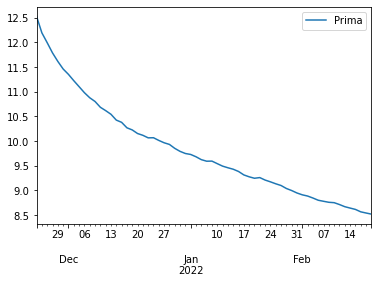

In [20]:
# cálculo de la prima que se necesita pagar para obtener put
put = pd.DataFrame({'Prima':np.exp(-mu_r*ndays) \
              *np.fmax(K-S_T2, 0).mean(axis=1)}, index=dates)
put.plot();
put.iloc[-1]

### Valuación usando simulación: modelo normal para los rendimientos

In [21]:
# Hallar media y desviación estándar muestral de los rendimientos logarítmicos
mu = ret_aapl.mean()[0]
sigma = ret_aapl.std()[0]
mu, sigma

(0.0012772721649051066, 0.018513767814433556)

In [22]:
# Tasa de bonos de 1 yr de fecha 19/11/21 -> 0.18%
r = 0.0018/360 # Tasa diaria

In [23]:
#Simularemos el tiempo de contrato desde HOY hasta la fecha de Expiry
today = pd.Timestamp(date.today())
expiry = pd.to_datetime('2022-02-18')

nscen = 10
dates = pd.date_range(start=today, end = expiry, freq='B')
ndays = len(dates)
dates

DatetimeIndex(['2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02',
               '2021-12-03', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
               '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21',
               '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27',
               '2022-01-28', '2022-01-31', '2022-02-01', '2022-02-02',
               '2022-02-03', '2022-02-04', '2022-02-07', '2022-02-08',
      

In [24]:
# Generamos 10 escenarios de rendimientos simulados y guardamos en un dataframe
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r, index=dates)
sim_ret.cumsum()
# Las columnas son los escenarios y las filas son las días de contrato

,0,1,2,...,7,8,9
2021-11-23,3.140e-02,0.012,0.023,...,-0.004,-0.019,-0.028
2021-11-24,1.292e-02,0.005,0.016,...,-0.032,0.004,-0.018
2021-11-25,-8.395e-03,-0.057,0.035,...,-0.027,0.005,-0.010
2021-11-26,-4.989e-04,-0.055,0.026,...,-0.006,-0.019,-0.014
2021-11-29,3.442e-03,-0.045,0.081,...,0.028,-0.052,-0.014
...,...,...,...,...,...,...,...
2022-02-14,2.330e-01,-0.159,0.006,...,-0.019,0.042,0.207
2022-02-15,2.027e-01,-0.183,0.006,...,-0.013,0.034,0.205
2022-02-16,2.104e-01,-0.183,-0.006,...,-0.006,0.046,0.197
2022-02-17,2.080e-01,-0.188,-0.025,...,-0.005,0.051,0.188


In [25]:
# Con los rendimientos simulados, calcular los escenarios de precios respectivos:
S0 = closes_aapl.iloc[-1,0]  # Condición inicial del precio a simular
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes

,0,1,2,...,7,8,9
2021-11-23,166.559,163.327,165.210,...,160.786,158.325,156.918
2021-11-24,163.509,162.272,163.983,...,156.280,162.103,158.470
2021-11-25,160.061,152.509,167.076,...,157.057,162.181,159.760
2021-11-26,161.329,152.741,165.635,...,160.448,158.438,159.208
2021-11-29,161.967,154.350,174.993,...,166.045,153.203,159.238
...,...,...,...,...,...,...,...
2022-02-14,203.768,137.727,162.413,...,158.412,168.374,198.533
2022-02-15,197.689,134.456,162.370,...,159.254,166.985,198.104
2022-02-16,199.216,134.367,160.431,...,160.421,169.053,196.641
2022-02-17,198.730,133.711,157.395,...,160.588,169.937,194.711


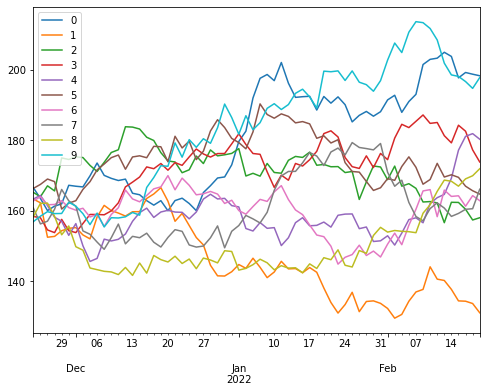

In [26]:
# visualizamos las simulaciones de precios
sim_closes.plot(figsize=(8,6));

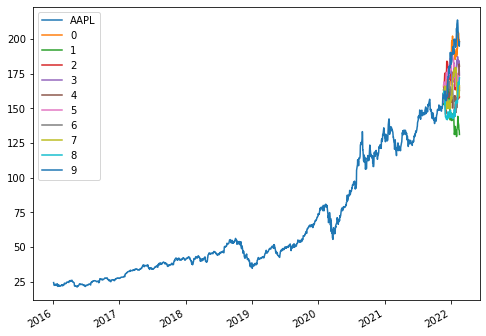

In [30]:
# Se muestran los precios simulados con los precios descargados
pd.concat([closes_aapl,sim_closes]).plot(figsize=(8,6));


In [31]:
Hoy = date.today()
nscen = 100000
dates = pd.date_range(start= Hoy, periods = ndays)
ndays = len(dates)
S0 = closes_aapl.iloc[-1,0]  # Condición inicial del precio a simular

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul = pd.concat([closes_aapl.T,strike.T,sim_closes.T]).T
#simul.plot(figsize=(8,6),legend=False);
sim_closes

,0,1,2,...,99997,99998,99999
2021-11-23,157.664,153.669,163.508,...,154.317,158.894,160.108
2021-11-24,153.753,157.505,166.493,...,154.126,163.152,160.205
2021-11-25,153.521,155.434,163.151,...,149.565,159.095,159.462
2021-11-26,152.672,154.518,165.475,...,151.707,156.479,163.887
2021-11-27,153.900,153.068,166.768,...,148.217,157.847,166.710
...,...,...,...,...,...,...,...
2022-01-21,158.050,165.239,151.944,...,133.524,194.781,133.303
2022-01-22,156.203,166.838,153.222,...,138.418,194.115,132.678
2022-01-23,156.426,164.549,155.184,...,140.200,188.442,134.492
2022-01-24,155.774,161.964,153.391,...,138.440,186.746,135.595


In [32]:
sim_closes.iloc[0, :] = closes_aapl.iloc[-1]
sim_closes

,0,1,2,...,99997,99998,99999
2021-11-23,161.410,161.410,161.410,...,161.410,161.410,161.410
2021-11-24,153.753,157.505,166.493,...,154.126,163.152,160.205
2021-11-25,153.521,155.434,163.151,...,149.565,159.095,159.462
2021-11-26,152.672,154.518,165.475,...,151.707,156.479,163.887
2021-11-27,153.900,153.068,166.768,...,148.217,157.847,166.710
...,...,...,...,...,...,...,...
2022-01-21,158.050,165.239,151.944,...,133.524,194.781,133.303
2022-01-22,156.203,166.838,153.222,...,138.418,194.115,132.678
2022-01-23,156.426,164.549,155.184,...,140.200,188.442,134.492
2022-01-24,155.774,161.964,153.391,...,138.440,186.746,135.595


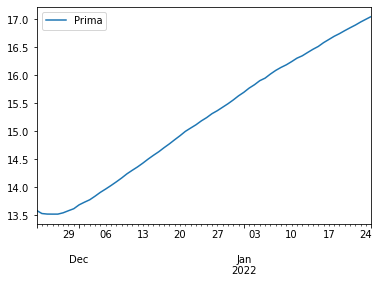

In [33]:
# se calcula la prima que se tiene que pagar para el put
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(K-sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();


In [34]:
#La valuación de la opción es
put.iloc[-1]

Prima    17.044
Name: 2022-01-25 00:00:00, dtype: float64

In [35]:
# Intervalo de confianza del 99%
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(16.845882030713238, 17.241911605074687)
(16.84588581030287, 17.241907825485054)


### Precios simulados usando técnicas de reducción de varianza

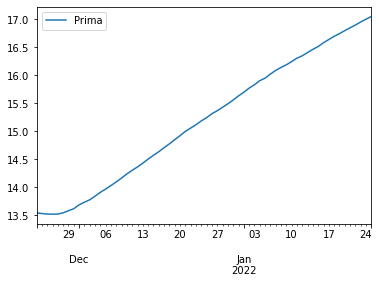

In [36]:
# Usando muestreo estratificado----> #estratros = nscen
U = (np.arange(0,nscen)+np.random.rand(ndays,nscen))/nscen
Z = st.norm.ppf(U)

sim_ret2 = pd.DataFrame(sigma*Z+r,index=dates)
sim_closes2 = S0*np.exp(sim_ret.cumsum())

# Función de pago
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike-sim_closes2,np.zeros([ndays,nscen])).T.mean()}, index=dates)
put.plot();

In [37]:
#La valuación de la opción es:
put.iloc[-1]

Prima    17.044
Name: 2022-01-25 00:00:00, dtype: float64

In [38]:
# intervalo de confianza 99%
confianza = 0.99
sigma_est = sim_closes2.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)


(16.845882030713238, 17.241911605074687)
(16.845882030713238, 17.241911605074687)


### Análisis de la distribución de los rendimientos

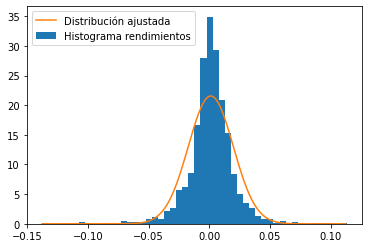

In [39]:
# ajustando norm
ren = calc_daily_ret(closes_aapl) # rendimientos 
y,x,des = plt.hist(ren['AAPL'],bins=50,density=True,label='Histograma rendimientos')

mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal
# Valores máximo y mínimo de los rendiemientos a generar
ren_max = max(x);ren_min = min(x)
# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
# Generación de la normal ajustado con los parámetros encontrados
curve_fit = st.norm.pdf(ren_gen,loc=mu_fit,scale=sd_fit)
plt.plot(ren_gen,curve_fit,label='Distribución ajustada')
plt.legend()
plt.show()


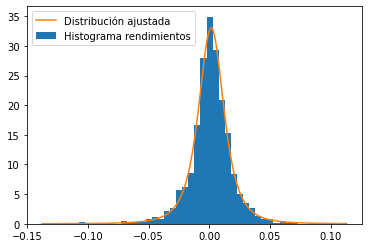

In [40]:
# ajustando t
ren = calc_daily_ret(closes_aapl) # rendimientos 
y,x,des = plt.hist(ren['AAPL'],bins=50,density=True,label='Histograma rendimientos')

dof,mu_fit,sd_fit = st.t.fit(ren.values) # Se ajustan los parámetros de una normal
# Valores máximo y mínimo de los rendiemientos a generar
# ren_max = max(x);ren_min = min(x)
# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
# Generación de la normal ajustado con los parámetros encontrados
curve_fit = st.t.pdf(ren_gen, df=dof,loc=mu_fit,scale=sd_fit)
plt.plot(ren_gen,curve_fit,label='Distribución ajustada')
plt.legend()
plt.show()

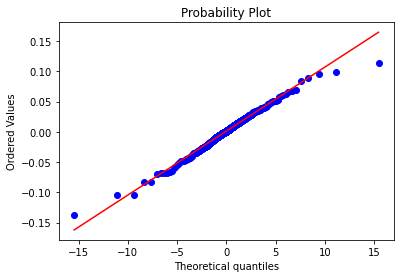

In [41]:
st.probplot(ren['AAPL'],sparams= dof, dist='t', plot=plt);

### Valuación usando simulación: uso del histograma de rendimientos

In [42]:
# cantidad de días y número de escenarios de simulación
ndays = 109 
nscen = 10

In [43]:
#las probabilidades de ocurrencia, lo que se llamó como variable y
prob = y/np.sum(y)
values = x[1:]

In [44]:
#generamos los números aleatorios correspondientes a los rendimientos (tantos como días por número de escenarios).
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range(start=Hoy,periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_ret_hist

,0,1,2,...,7,8,9
2021-11-23,-0.012,0.058,0.018,...,-0.007,0.008,0.038
2021-11-24,0.008,-0.022,-0.017,...,0.063,-0.007,0.003
2021-11-25,0.018,0.008,0.003,...,0.008,0.003,-0.007
2021-11-26,0.018,0.038,-0.002,...,0.018,-0.027,0.018
2021-11-27,0.013,-0.022,-0.007,...,0.003,0.003,0.003
...,...,...,...,...,...,...,...
2022-03-07,0.008,0.018,-0.012,...,0.003,0.018,0.008
2022-03-08,-0.002,0.013,0.003,...,0.028,-0.007,0.003
2022-03-09,0.103,0.018,-0.012,...,0.008,0.008,0.003
2022-03-10,0.003,0.013,0.008,...,0.003,0.013,0.008


In [45]:
sim_closes_hist = (closes_aapl.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
sim_closes_hist

,0,1,2,...,7,8,9
2021-11-23,159.441,171.043,164.314,...,160.243,162.673,167.644
2021-11-24,160.688,167.269,161.497,...,170.660,161.497,168.111
2021-11-25,163.579,168.578,161.946,...,171.996,161.946,166.895
2021-11-26,166.521,175.089,161.583,...,175.089,157.580,169.897
2021-11-27,168.668,171.226,160.415,...,175.576,158.018,170.370
...,...,...,...,...,...,...,...
2022-03-07,192.501,174.998,251.143,...,221.537,269.418,327.648
2022-03-08,192.070,177.254,251.841,...,227.796,267.469,328.559
2022-03-09,212.935,180.443,248.768,...,229.579,269.562,329.472
2022-03-10,213.527,182.769,250.715,...,230.217,273.038,332.050


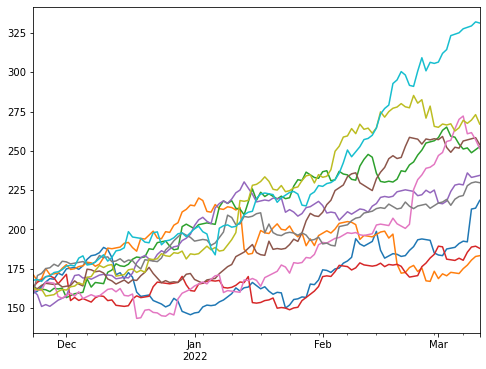

In [46]:
sim_closes_hist.plot(figsize=(8,6),legend=False);

Text(0.5, 1.0, 'Simulación usando el histograma de los rendimientos')

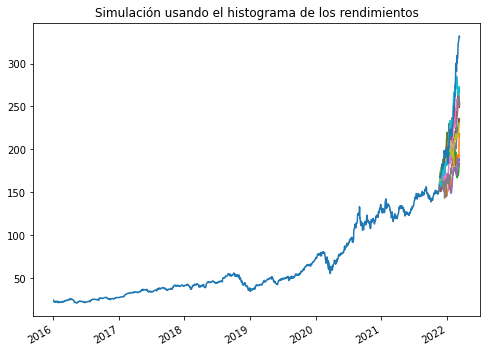

In [47]:
pd.concat([closes_aapl,sim_closes_hist]).plot(figsize=(8,6),legend=False);
plt.title('Simulación usando el histograma de los rendimientos')

In [48]:
ndays = 109
nscen = 10000
freq, values = np.histogram(ret_aapl+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-10-29',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_aapl.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())

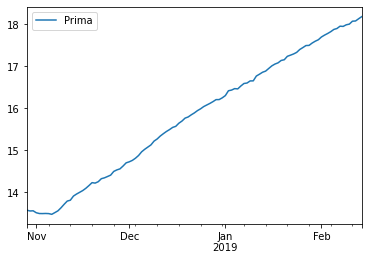

In [49]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
put_hist.plot();

In [50]:
put_hist.iloc[-1]

Prima    18.182
Name: 2019-02-14 00:00:00, dtype: float64

In [51]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)


(17.54896712033981, 18.814639213799396)
(17.54896712033981, 18.814639213799396)


Para la prima de la opción de Apple tenemos varias opciones ya que lo calculamos de diferentes maneras:
 - Valuación usando simulación: uso del histograma de rendimientos -> 18.182
 - Rendimiento Logaritmico -> 18.182
 - Valuación usando simulación: modelo normal para los rendimientos -> 17.044
 - Precios simulados usando técnicas de reducción de varianza -> 17.044

Concluimos que se debería de tomar 17.004 como la prima. Como se usó un intervalo de confianza del 99% entonces los resultados son aceptables.

## Resultados teoricos del método de valuación de Black-Scholes

In [52]:
Hoy = date.today()

dates = pd.date_range(start= Hoy, periods = ndays, freq='B')

ndays = len(dates)
nscen = 100000

S0 = closes_aapl.iloc[-1]  
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0[0]*np.exp(sim_ret.cumsum())

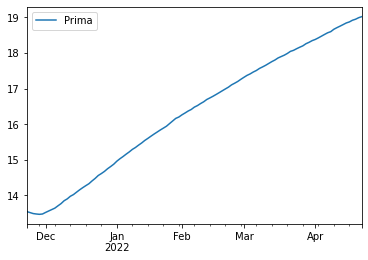

In [53]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
#put usando black scholes
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike-sim_closes,0).mean(axis=1)}, index=dates)
put.plot();

In [54]:
put.iloc[-1]

Prima    19.021
Name: 2022-04-22 00:00:00, dtype: float64

In [55]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(18.760430249517107, 19.282414237992434)


Con un nivel de confianza de 0.99 obtuvimos que la prima deberia de ser 19.021 con el metodo de los resultados teoricos del black scholes.

Podemos concluir que la prima para nuestra opción puede estar en el rango de 17.044 y 19.2824.